# extract features from each publisher and advertiser webpage 

In [7]:
# database packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# math
import pandas as pd
import numpy as np
%matplotlib inline

# nlp
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import re
import nltk

In [8]:
# input from the webpage db
dbname = 'urx'
username = 'noahburbank'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [10]:
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM webpage_data_table_exp1;
"""
webpage_data = pd.read_sql_query(sql_query,con)
webpage_data.columns

Index([u'index', u'starturl', u'start_domain', u'start_titles',
       u'start_description', u'start_extracted_content',
       u'start_stemmed_word_list', u'_unit_it', u'endurl', u'end_domain',
       u'end_titles', u'end_decription', u'end_extracted_content',
       u'end_stemmed_word_list'],
      dtype='object')

# tfidf 

In [11]:
# tokenizer
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
#### tf-idf  

def get_tfidf_cosine_measure(start_texts, end_texts):
    # combine all of the texts
    all_texts = list(start_texts) + list(end_texts)
    
    # initialize and train 
    tfidf = TfidfVectorizer(tokenizer=tokenize_and_stem, stop_words='english')
    tfs = tfidf.fit_transform(all_texts)

    # make the cosine similarity matrix 
    cosine_mat = tfs * tfs.T
    
    # grab the cosine similarity measure for each start/end url pair and output as a list
    cosine_list = []
    indexer = range(0, len(start_texts))
    for index in indexer:
        cosine_val = cosine_mat[index, index + len(start_texts)]
        cosine_list.append(cosine_val)
    return cosine_list, tfidf

In [13]:
# get cosine similarity for each piece of the document 
title_cosine, title_tfidf = get_tfidf_cosine_measure(webpage_data['start_titles'], webpage_data['end_titles'])
body_cosine, body_tfidf = get_tfidf_cosine_measure(webpage_data['start_extracted_content'], webpage_data['end_extracted_content'])
meta_cosine, meta_tfidf = get_tfidf_cosine_measure(webpage_data['start_description'], webpage_data['end_decription'])

# n-grams

In [14]:
# trying the one, two and three grams
import ngram
one_grams = []
two_grams = []
three_grams = []

for line in webpage_data.iterrows():
    string1 = line[1]['start_titles']
    string2 = line[1]['end_titles']
    one_gram = ngram.NGram.compare(string1, string2, N=1)
    two_gram = ngram.NGram.compare(string1, string2, N=2)
    three_gram = ngram.NGram.compare(string1, string2, N=3)
    one_grams.append(one_gram)
    two_grams.append(two_gram)
    three_grams.append(three_gram)

In [15]:
description_one_grams = []
description_two_grams = []
description_three_grams = []

for line in webpage_data.iterrows():
    string1 = line[1]['start_description']
    string2 = line[1]['end_decription']
    one_gram = ngram.NGram.compare(string1, string2, N=1)
    two_gram = ngram.NGram.compare(string1, string2, N=2)
    three_gram =ngram.NGram.compare(string1, string2, N=3)
    description_one_grams.append(one_gram)
    description_two_grams.append(two_gram)
    description_three_grams.append(three_gram)
    

# longest common substring

In [16]:
 def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for i in xrange(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in xrange(1, 1 + len(s1)):
        for y in xrange(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

In [17]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

lcfs = []
limiter = 0
desc_vectors = []
body_vectors = []
title_vectors = []
title_to_body = []

def lcf_strings(string1, string2):
    lcf = longest_common_substring(string1, string2)
    lcfs.append(lcf)
    
    x = tokenize_only(lcf)
    x = set(x).difference(stopwords)
    if x != set():
        if len(max(x)) < 3:
            x = set()
    return x

In [18]:
i = len(webpage_data)
for line in webpage_data.iterrows():
    
    desc_vectors.append(lcf_strings(line[1]['start_description'], line[1]['end_decription']))
    body_vectors.append(lcf_strings(line[1]['start_extracted_content'], line[1]['end_extracted_content']))
    title_vectors.append(lcf_strings(line[1]['start_titles'], line[1]['end_titles']))
    title_to_body.append(lcf_strings(line[1]['start_titles'], line[1]['end_extracted_content']))
    if (i % 25) == 0:
        print i
    i -= 1

950
925
900
875
850
825
800
775
750
725
700
675
650
625
600
575
550
525
500
475
450
425
400
375
350
325
300
275
250
225
200
175
150
125
100
75
50
25


In [19]:
def process_lcf_list(lcf_list, cutoff):

    # convert to strings
    vec = []
    for item in lcf_list:
        vec.append(str(item))
    
    # make dictionary with counts of each unique term (set of sets converted to string)
    unique_sets = list(set(vec))
    zeros = [0] * len(set(vec))
    set_lists = dict(zip(unique_sets, zeros))
    for desc_set in vec:
        set_lists[desc_set] += 1
       
    #print set_lists
    
    # evaluate where to cutoff these values
    print "there are " + str(len(vec)) + ' entries'
    print 'of which ' + str(len(set_lists.values())) +' are unique values'
    print 'of which ' + str(pd.Series(data=set_lists.values()).apply(lambda x: x > cutoff).sum()) + ' are too frequent to matter'
    print 
    print 'too frequent entries:' + " for " + str(cutoff) + " as cutoff"
    
    # find the items 
    acceptable_sets = []
    lcf_score = []
    for line in set_lists:
        if set_lists[line] < cutoff and set_lists[line] > 1:
            acceptable_sets.append(line)
#    print 'these are the acceptable sets'
#    print acceptable_sets
    
    #calculate the score for each one
    for line in lcf_list:
        if str(line) in set(acceptable_sets):
            lcf_score.append(1)
        else:
            lcf_score.append(0)
            
            
# it looks like 10 is a pretty good choice 
    return lcf_score

In [20]:
desc_lcf_score = process_lcf_list(desc_vectors,6)

there are 950 entries
of which 231 are unique values
of which 5 are too frequent to matter

too frequent entries: for 6 as cutoff


In [21]:
title_lcf_score = process_lcf_list(title_vectors,6)

there are 950 entries
of which 333 are unique values
of which 5 are too frequent to matter

too frequent entries: for 6 as cutoff


In [22]:
body_lcf_score = process_lcf_list(body_vectors, 6)


there are 950 entries
of which 259 are unique values
of which 10 are too frequent to matter

too frequent entries: for 6 as cutoff


# named entitiy recognition

In [23]:
## named entity recognition 
from nltk.tag.stanford import StanfordNERTagger
st = StanfordNERTagger('/Users/noahburbank/Python/stanford-ner/stanford-ner-2014-06-16/classifiers/english.all.3class.distsim.crf.ser.gz',
                       '/Users/noahburbank/Python/stanford-ner/stanford-ner-2014-06-16/stanford-ner-3.4.jar')

In [24]:
# make the string back into a list object

# function to get lists back into lists(they're actually sets though, so the order is an issue)
def strings_back_to_lists(string):
    string = string.replace('{', '')
    string = string.replace('}', '')
    string = unicode(string, errors='ignore')

    mylist = string.split(',')
    
    return mylist

In [25]:
##  this will extracted the person named entities for a each page

def extract_named_entities(word_set, max):
    counter = 0
    named_entities = []
    for word_list in word_set:
        word_list = strings_back_to_lists(word_list)
        tuple_list = st.tag(word_list)


        entities = []
        for element in tuple_list:
            if element[1] == 'PERSON':
                entities.append(element[0])

        named_entities.append(entities)

        counter += 1
        print entities
#        print 
#        print 
        if counter == max:
            break
    return named_entities

In [28]:
## extract named entities for each part of the 

start_body_ner = extract_named_entities(webpage_data.start_stemmed_word_list, 10000)
end_body_ner = extract_named_entities(webpage_data.end_stemmed_word_list, 10000)

[u'lavern', u'baker']
[u'lavern', u'baker']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'doc', u'mcstuffin']
[u'doc', u'mcstuffin']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'zac', u'efron', u'nikki', u'blonski', u'amanda', u'byne', u'elijah', u'kelley']
[u'zac', u'efron', u'nikki', u'blonski', u'amanda', u'byne', u'elijah', u'kelley']
[]
[]
[]
[]
[]
[]
[]
[u'saul', u'hudson', u'michael', u'mckagan', u'jeffrey', u'isbel', u'steven', u'adler', u'montel', u'jordan', u'ricki', u'walter']
[u'saul', u'hudson', u'michael', u'mckagan', u'jeffrey', u'isbel', u'steven', u'adler', u'montel', u'jordan', u'ricki', u'walter']
[]
[]
[]
[]
[]
[]
[]
[]
[u'jame', u'holden', u'jame', u'holden', u'jame', u'holden', u'rihanna', u'jessi', u'lanza']
[u'jame', u'holden', u'jame', u'holden', u'jame', u'holden', u'rihanna', u'jessi', u'lanza']
[u'anna', u'von', u'hausswolff', u'anna', u'von', u'hausswolff', u'rihanna', u'jessi', u'lanza']
[u'anna', u'von', u'hausswolff', u'anna', u'von', u'hausswolff', u'rihanna', u'jessi', u'lanza

In [29]:
start_title_ner = extract_named_entities(webpage_data.start_titles, 10000)
end_title_ner = extract_named_entities(webpage_data.end_titles, 10000)

[u'LAVERN']
[u'LAVERN']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'DOC']
[u'DOC']
[]
[]
[u'HEATHER']
[u'HEATHER']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'BETTE']
[u'BETTE']
[]
[u'James']
[u'James']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'Steve']
[u'Steve']
[]
[]
[]
[]
[]
[u'Jean-Michel']
[u'Jean-Michel']
[]
[]
[]
[]
[]
[u'Reba']
[u'Reba']
[]
[]
[u'Brantley']
[u'Brantley']
[]
[]
[u'Missy']
[u'Missy']
[]
[]
[u'Brian']
[u'Brian']
[]
[]
[]
[]
[u'Joe']
[]
[]
[]
[]
[u'Joe']
[u'Ted']
[u'Ted']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'August']
[u'August']
[]
[]
[]
[]
[]
[]
[u'Ed']
[u'Ed']
[]
[]
[]
[]
[u'BRUCE']
[u'BRUCE']
[]
[]
[]
[]
[]
[u'GERARDO']
[]
[u'GERARDO']
[]
[]
[u'JUSTIN']
[]
[u'JUSTIN']
[]
[]
[]
[u'BRIAN']
[]
[]
[]
[u'BRIAN']
[u'John']
[]
[]
[u'MARVIN']
[u'MARVIN']
[]
[]
[]
[]
[u'KAREN']
[u'KAREN']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'Jeff']
[u'Jeff']
[u'Seu']
[u'Seu']
[u'Papa'

In [33]:
start_desc_ner = extract_named_entities(webpage_data.start_description, 10000)
end_desc_ner = extract_named_entities(webpage_data.end_decription, 10000)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'Anna', u'von']
[u'Anna', u'von']
[]
[u'Marea']
[]
[u'James']
[u'James']
[]
[]
[u'Marea']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'Halou']
[u'Halou']
[]
[]
[u'Bruce', u'Willis']
[u'Bruce', u'Willis']
[u'Ramzi']
[]
[u'Ramzi']
[]
[]
[u'Gerardo']
[]
[u'Gerardo']
[u'Rich', u'Homie', u'Quan']
[u'Rich', u'Homie', u'Quan']
[u'Justin']
[]
[u'Justin']
[]
[]
[]
[u'Brian']
[]
[]
[]
[u'Brian']
[u'Boogie']
[]
[]
[u'Marvin', u'Gaye']
[u'Marvin', u'Gaye']
[]
[]
[]
[]
[u'Karen']
[u'Karen']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[u'Boogie']
[]
[]
[]
[]
[u'Johnny']
[u'Johnny']
[]
[]
[]
[]
[]
[]
[]
[]
[]

In [34]:
# back to string
def list_to_string(input_list):
    not_unicode = []
    for item in input_list:
        not_unicode.append(str(item))
    string = str(not_unicode)
    string = string.replace(',','')
    string = string.replace('\'', '')
    string = string.replace('[', '')
    string = string.replace(']', '')
    return string

def ner_to_string_list(ner_list):
    new_list = []
    for item in ner_list:
        new_list.append(list_to_string(item))
    return new_list

In [35]:
# convert them all into lists of strings so that my tfidf function works with them 
end_body_ner_str = ner_to_string_list(end_body_ner)
start_body_ner_str = ner_to_string_list(start_body_ner)
end_title_ner_str = ner_to_string_list(end_title_ner)
start_title_ner_str = ner_to_string_list(start_title_ner)
end_desc_ner_str = ner_to_string_list(end_desc_ner)
start_desc_ner_str = ner_to_string_list(start_desc_ner)

# calculate tfidf and cosine similarity here 
body_ner_cosine, body_ner_tfidf = get_tfidf_cosine_measure(start_body_ner_str, end_body_ner_str)
title_ner_cosine, title_ner_tfidf = get_tfidf_cosine_measure(start_title_ner_str, end_title_ner_str)
desc_ner_cosine, desc_ner_tfidf = get_tfidf_cosine_measure(start_desc_ner_str, end_desc_ner_str)

In [36]:
#### an alternative is to just take the intersection and see if that's going to help,
#alhtough to be honest it should work out roughly the same as the tfidf really

# function to find the size of the intersection of the ner's for start and end url pieces 

def ner_intersection(ner_list1, ner_list2):
    intersections = []
    indexer = range(0,len(end_body_ner))
    
    for index in indexer: 
        start_ner_list = set(ner_list1[index])
        end_ner_list = set(ner_list2[index])
        intersection = start_ner_list.intersection(end_ner_list)
        intersections.append(len(intersection))
    
    return intersections
# a
body_ner_intersections = ner_intersection(start_body_ner, end_body_ner)
title_ner_intersections = ner_intersection(start_title_ner, end_title_ner)
desc_ner_intersections = ner_intersection(start_desc_ner, end_desc_ner)

# aggregate all of this into a single df

In [37]:
# create df with extracted signals
signal_df = pd.DataFrame()
signal_df['_unit_id'] = webpage_data['_unit_it']

#tfidf cosine similarity
signal_df['title_sim'] = title_cosine 
signal_df['body_sim'] = body_cosine
signal_df['meta_sim'] = meta_cosine

#ngrams
signal_df['one_grams'] = one_grams
signal_df['two_grams'] = two_grams
signal_df['three_grams'] = three_grams

#meta 
signal_df['meta_one_gram'] = description_one_grams
signal_df['meta_two_gram'] = description_two_grams
signal_df['meta_three_gram'] = description_three_grams

# start and end urls
signal_df['starturl'] = webpage_data['starturl']
signal_df['endurl'] = webpage_data['endurl']

# domains
signal_df['start_domain'] = webpage_data['start_domain']
signal_df['end_domain'] = webpage_data['end_domain']

# quant_lcf
signal_df['body_lcf_score'] = body_lcf_score
signal_df['title_lcf_score'] = title_lcf_score
signal_df['desc_lcf_score'] = desc_lcf_score

# # ner cosine values 
signal_df['body_ner_cosine'] = body_ner_cosine
signal_df['title_ner_cosine'] = title_ner_cosine
signal_df['desc_ner_cosine'] = desc_ner_cosine

# # ner intersction values 
signal_df['body_ner_intersection'] = body_ner_intersections
signal_df['title_ner_intersection'] = title_ner_intersections
signal_df['desc_ner_intersectipon'] = desc_ner_intersections

In [38]:
# filter by the unit_id pairs for which I have a a decent aggregated score 
scores_df = pd.read_csv('scores_exp2.csv')
majority_set = set(scores_df._unit_id)
signal_df['has_majority'] = signal_df['_unit_id'].apply(lambda x: x in majority_set)
signal_df = signal_df[signal_df['has_majority'] == 1]

#add in the scores for histograms to evaluate signals 
id_score_dict = dict(zip(scores_df._unit_id, scores_df.score))
score_list = []
for unit_id in signal_df._unit_id:
    score_list.append(id_score_dict[unit_id])
signal_df['score'] = score_list

# drop the has majority column
del signal_df['has_majority']

# visualize all of features 
basic first pass assessment, ensure that green is roughly to the right of blue

In [39]:
print signal_df.groupby('score').mean()

           _unit_id  title_sim  body_sim  meta_sim  one_grams  two_grams  \
score                                                                      
1      8.340204e+08   0.120005  0.050597  0.067839   0.321254   0.099373   
3      8.340204e+08   0.331861  0.139258  0.125497   0.330373   0.130871   

       three_grams  meta_one_gram  meta_two_gram  meta_three_gram  \
score                                                               
1         0.042491       0.349089       0.130832         0.045281   
3         0.079287       0.326600       0.121274         0.047873   

       body_lcf_score  title_lcf_score  desc_lcf_score  body_ner_cosine  \
score                                                                     
1            0.153274         0.183036        0.119048         0.011907   
3            0.367816         0.517241        0.350575         0.102253   

       title_ner_cosine  desc_ner_cosine  body_ner_intersection  \
score                                             

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: title_sim, dtype: object

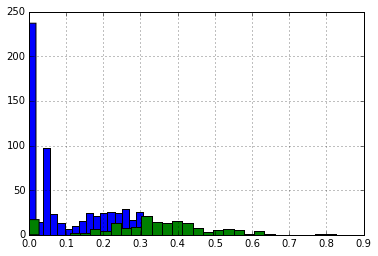

In [40]:
### now that we can make some decent graphs to evalute the quality of my features!!! 
signal_df['majority'] = signal_df['score']
signal_df.groupby('majority')['title_sim'].hist(bins= 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: body_sim, dtype: object

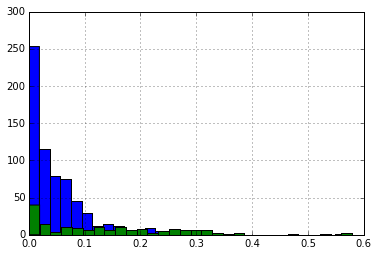

In [41]:
signal_df.groupby('majority')['body_sim'].hist(bins= 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: meta_sim, dtype: object

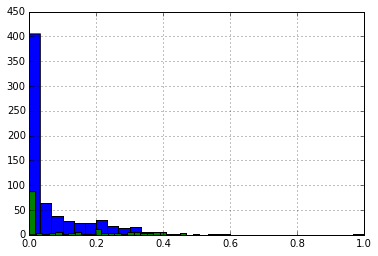

In [42]:
signal_df.groupby('majority')['meta_sim'].hist(bins= 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: one_grams, dtype: object

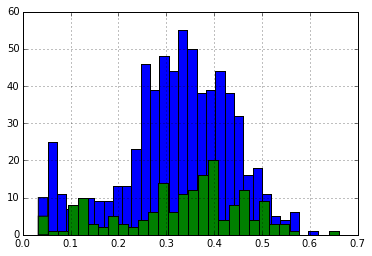

In [43]:
signal_df.groupby('majority')['one_grams'].hist(bins = 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: two_grams, dtype: object

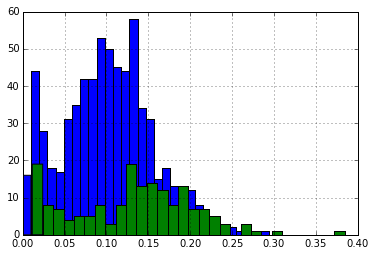

In [44]:
signal_df.groupby('majority')['two_grams'].hist(bins = 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: three_grams, dtype: object

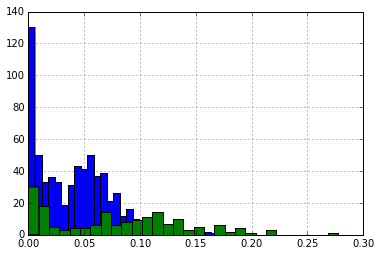

In [45]:
signal_df.groupby('majority')['three_grams'].hist(bins = 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: meta_one_gram, dtype: object

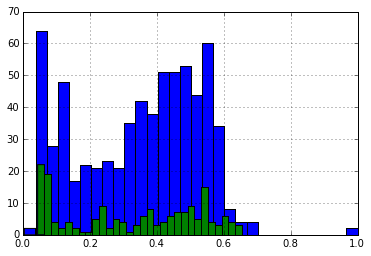

In [46]:
signal_df.groupby('majority')['meta_one_gram'].hist(bins = 30)


majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: meta_two_gram, dtype: object

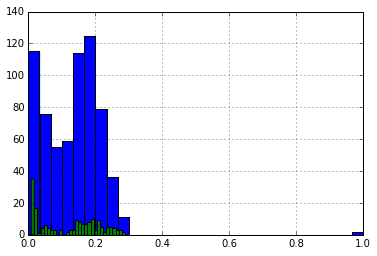

In [47]:
signal_df.groupby('majority')['meta_two_gram'].hist(bins = 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: meta_three_gram, dtype: object

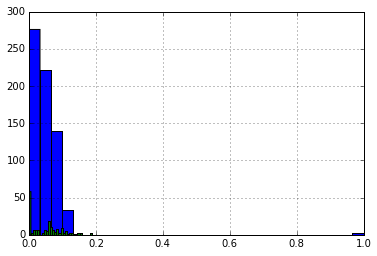

In [48]:
signal_df.groupby('majority')['meta_three_gram'].hist(bins = 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: body_lcf_score, dtype: object

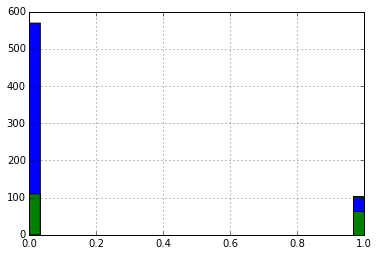

In [49]:
signal_df.groupby('majority')['body_lcf_score'].hist(bins = 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: title_lcf_score, dtype: object

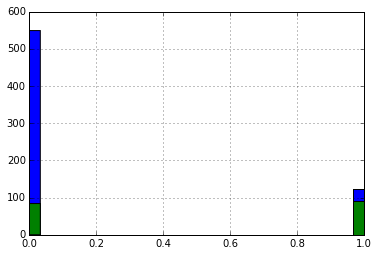

In [50]:
signal_df.groupby('majority')['title_lcf_score'].hist(bins = 30)

majority
1    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: desc_lcf_score, dtype: object

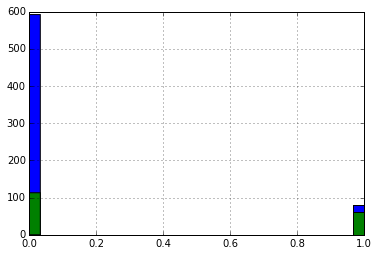

In [51]:
signal_df.groupby('majority')['desc_lcf_score'].hist(bins = 30)

majority
1    0.011907
3    0.102253
Name: body_ner_cosine, dtype: float64

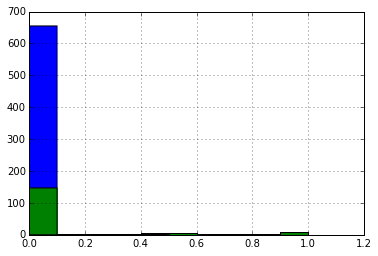

In [52]:
signal_df.groupby('majority')['body_ner_cosine'].hist(bins = 10)
signal_df.groupby('majority')['body_ner_cosine'].mean()

majority
1    0.012277
3    0.061588
Name: title_ner_cosine, dtype: float64

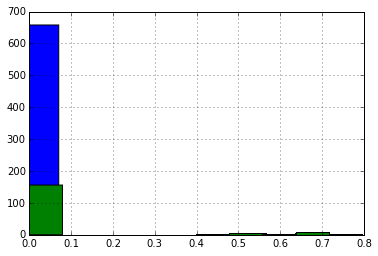

In [53]:
signal_df.groupby('majority')['title_ner_cosine'].hist(bins = 10)
signal_df.groupby('majority')['title_ner_cosine'].mean()

majority
1    0
3    0
Name: desc_ner_cosine, dtype: float64

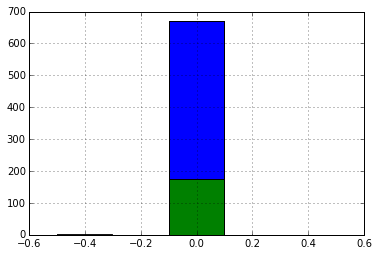

In [54]:
signal_df.groupby('majority')['desc_ner_cosine'].hist(bins = 5)
signal_df.groupby('majority')['desc_ner_cosine'].mean()

majority
1    0.011905
3    0.057471
Name: title_ner_intersection, dtype: float64

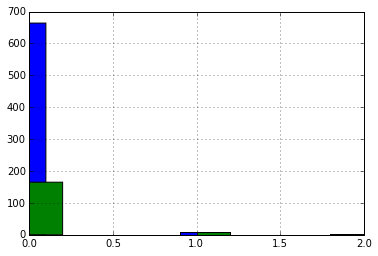

In [55]:
signal_df.groupby('majority')['title_ner_intersection'].hist(bins = 10)
signal_df.groupby('majority')['title_ner_intersection'].mean()

majority
1    0.044643
3    0.373563
Name: body_ner_intersection, dtype: float64

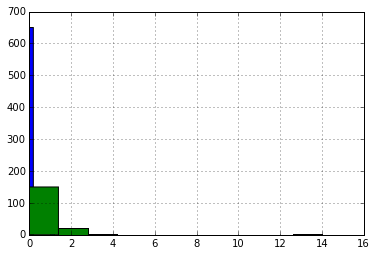

In [56]:
signal_df.groupby('majority')['body_ner_intersection'].hist(bins = 10)
signal_df.groupby('majority')['body_ner_intersection'].mean()

majority
1    0
3    0
Name: desc_ner_intersectipon, dtype: int64

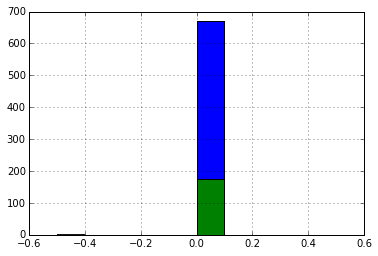

In [57]:
signal_df.groupby('majority')['desc_ner_intersectipon'].hist(bins = 10)
signal_df.groupby('majority')['desc_ner_intersectipon'].mean()

## output to database

In [58]:
# output to the unit pair signal db
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [59]:
signal_df.to_sql('signals_exp1', engine, if_exists = 'replace')